In [19]:
%matplotlib notebook

import random
from math import sqrt
import matplotlib.pyplot as plt

In [20]:
def initial_population(size, degree):
    population = []

    for _ in range(size):
        genome = []

        for _ in range(degree + 1):
            genome.append(random.uniform(-100, 100))

        population.append(genome)

    return population


In [21]:
def crossover(a, b):
    genome = []
    for left, right in zip(a, b):
        if random.random() < 0.5:
            genome.append(left)
        else:
            genome.append(right)
    return genome


In [22]:
def mutate(genome):
    genome = list(genome)
    for i in range(len(genome)):
        if random.random() < 0.9:
            genome[i] += random.uniform(-0.5, 0.5)
    return genome


In [23]:
def polynomial(x, coefficients):
    result = 0
    for degree, coefficient in enumerate(coefficients):
        result += coefficient * x**degree
    return result



In [24]:
def calculate_fitness(data, genome):
    error = 0
    for x, y in data:
        estimate = polynomial(x, genome)
        error += abs((y - estimate))
    return -error / len(data)

In [25]:
def next_generation(current_generation, fitness):
    junk_threshold = sorted(fitness)[int(len(fitness)*0.6)]
    elite = sorted(zip(current_generation, fitness), key=lambda i: i[1])[-1][0]

    breeding_population = {tuple(genome) for fitness, genome in zip(fitness, current_generation) if fitness > junk_threshold}

    children = [elite]
    while len(children) < len(current_generation):
        a = random.choice(list(breeding_population))
        b = random.choice(list(breeding_population - {a}))
        child = crossover(a, b)
        child = mutate(child)
        children.append(child)

    return children


In [26]:
def make_test_data(size, degree):
    coefficients = [random.uniform(-3, 3) for _ in range(degree+1)]
    #coefficients = [-2, -6/4, 3/4, 1/4]

    data = []
    while len(data) < size:
        x = random.uniform(-5, 5)
        y = polynomial(x, coefficients)# * random.uniform(0.9, 1.1)
        data.append((x, y))

    return data, coefficients


<IPython.core.display.Javascript object>


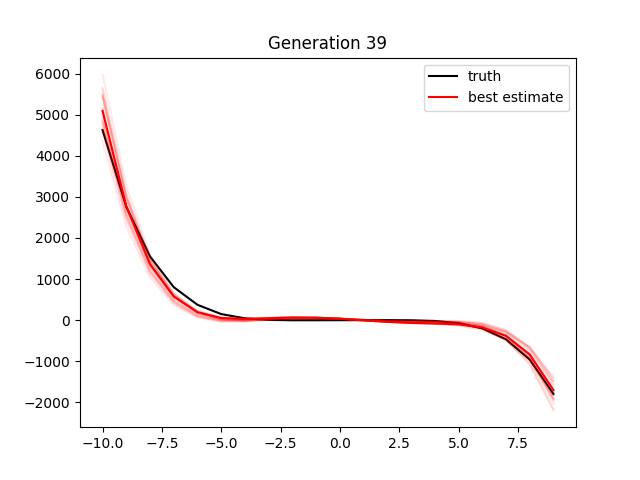

KeyboardInterrupt: 

In [27]:
degree = 5
population = initial_population(100, degree)
data, true_coefficients = make_test_data(50, degree)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

i = 0
while True:
   fitness = [calculate_fitness(data, genome) for genome in population]
   by_fitness = [genome for genome, _ in sorted(zip(population, fitness), key=lambda i: i[1])]
   xs = range(-10,10)
   ys = [polynomial(x/2, true_coefficients) for x in xs]
   ax.clear()
   ax.set_title(f"Generation {i}")
   ax.plot(xs, ys, color=(0.0, 0.0, 0.0, 1.0), label="truth")
   elite = by_fitness[-1]
   ys = [polynomial(x/2, elite) for x in xs]
   ax.plot(xs, ys, color=(1, 0.0, 0.0, 1.0), label="best estimate")
   for n in range(20):
       genome = by_fitness[-(n+1)]
       ys = [polynomial(x/2, genome) for x in xs]
       ax.plot(xs, ys, color=(1, 0.0, 0.0, 0.09))
   ax.legend()
   fig.canvas.draw()
   #print(f"Generation {i} Mean Fitness {sum(fitness) / len(fitness)} Max Fitness {max(fitness)}")
   population = next_generation(population, fitness)
   i += 1
